Hak Artem, MP CS-2
Neural Networks, Lab 2

Домашнє завдання 2: Використання глибоких мереж

Для виконання цього завдання, використайте код з попередніх практичних і домашніх.

Виберіть прикладну задачу, яку хочете вирішити за допомогою нейронних мереж. Знайдіть для неї датасет, наприклад, з kaggle.com.
Визначте які популярні архітектури можуть підійти для виконання задачі. Скористайтеся офіційною документацією для більшої інформації: https://pytorch.org/vision/stable/models.html.
Визначте основні компоненти моделі: функція втрат, функція метрики, яку базову архітектуру моделі (яку передтреновану модель) будете використовувати.
Використайте код з попередніх практичних і домашніх робіт та модифікуйте його для роботи з вашим датасетом та передтренованою моделлю.
Проведіть експерименти з обраними архітектурами, порівняйте їх, зробіть і напишіть висновки.
Зробіть fine-tuning передтренованої моделі та/або tuning гіпер (мета) параметрів.


Рішення необхідно оформити як .ipynb або .py файл з описом ваших роздумів (1-2 речення з коментарем щодо вашого застосування тих чи інших підходів і структур нейронних мереж).
https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

Я вибрав датасет для класифікації гральних карт за фото

https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import pandas as pd
import torchvision

from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torchvision.utils import make_grid

import random
from tqdm import tqdm
import numpy as np
import cv2
import time
import torch.optim as optim
import opendatasets as od
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [3]:
od.download(
    "https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification")

Skipping, found downloaded files in ".\cards-image-datasetclassification" (use force=True to force download)


In [4]:
train_dir = "./cards-image-datasetclassification/train/"
valid_dir = "./cards-image-datasetclassification/valid/"
test_dir = "./cards-image-datasetclassification/test/"

In [149]:
batch_size = 32
img_height = 80
img_width = 80

In [150]:
# Define transformations for your images
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),  # Resize images to a consistent size
    transforms.ToTensor(),        # Convert images to tensors
    # Add other transformations as needed (e.g., normalization)
])

In [151]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

In [152]:
validation_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

In [153]:
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(dataset=test_dataset, shuffle=False)

In [154]:
plt_size = 2
plt_images = 12

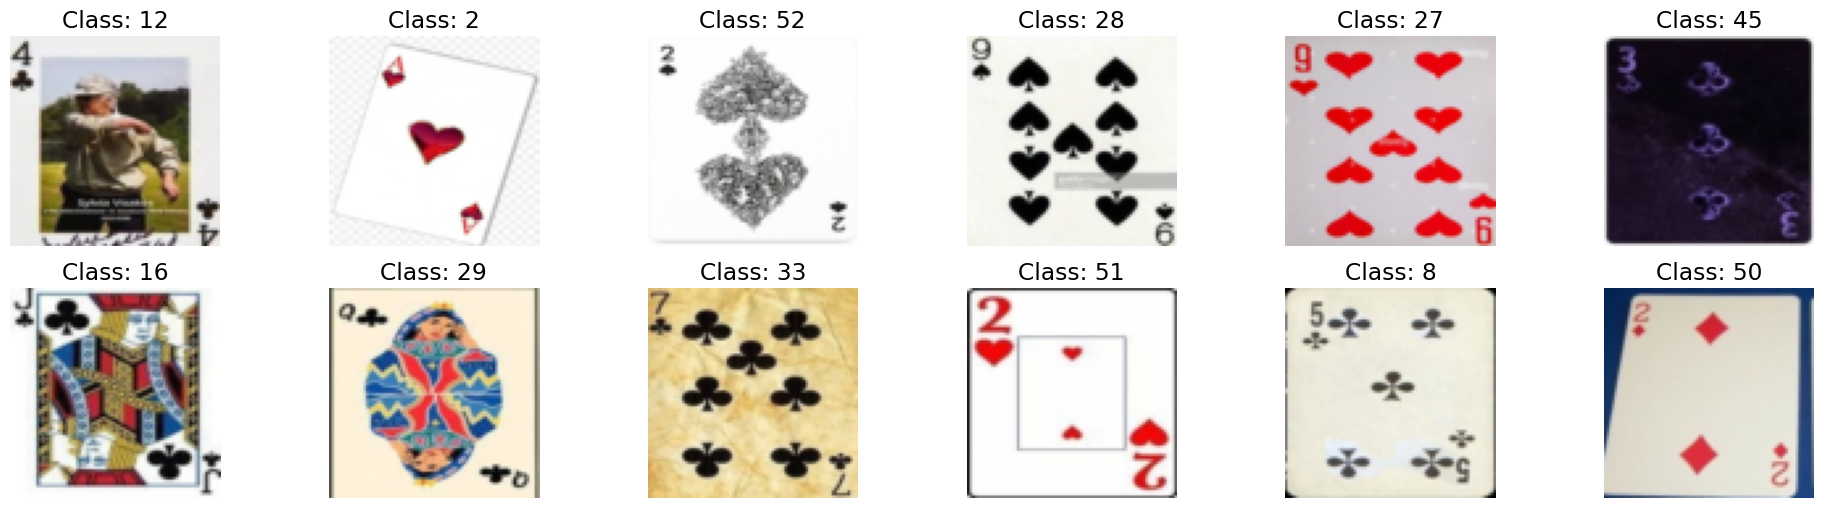

In [165]:
for (X_train, y_train) in train_loader:
    plt.figure(figsize=(plt_images * plt_size, 3 * plt_size))

    for i in range(plt_images):
        plt.subplot(2, plt_images // 2, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i].permute(1, 2, 0), cmap="gray")  # Reshape the tensor for display
        plt.title(f'Class: {y_train[i].item()}')

    break  # Display one batch
plt.show()

In [166]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

class_counts = defaultdict(int)  # Dictionary to store class counts

# Loop through the entire dataset to count class occurrences
for _, y_train in train_loader:
    for label in y_train.numpy():
        class_counts[label] += 1

# Convert dictionary to arrays for plotting
unique_classes, counts = zip(*class_counts.items())

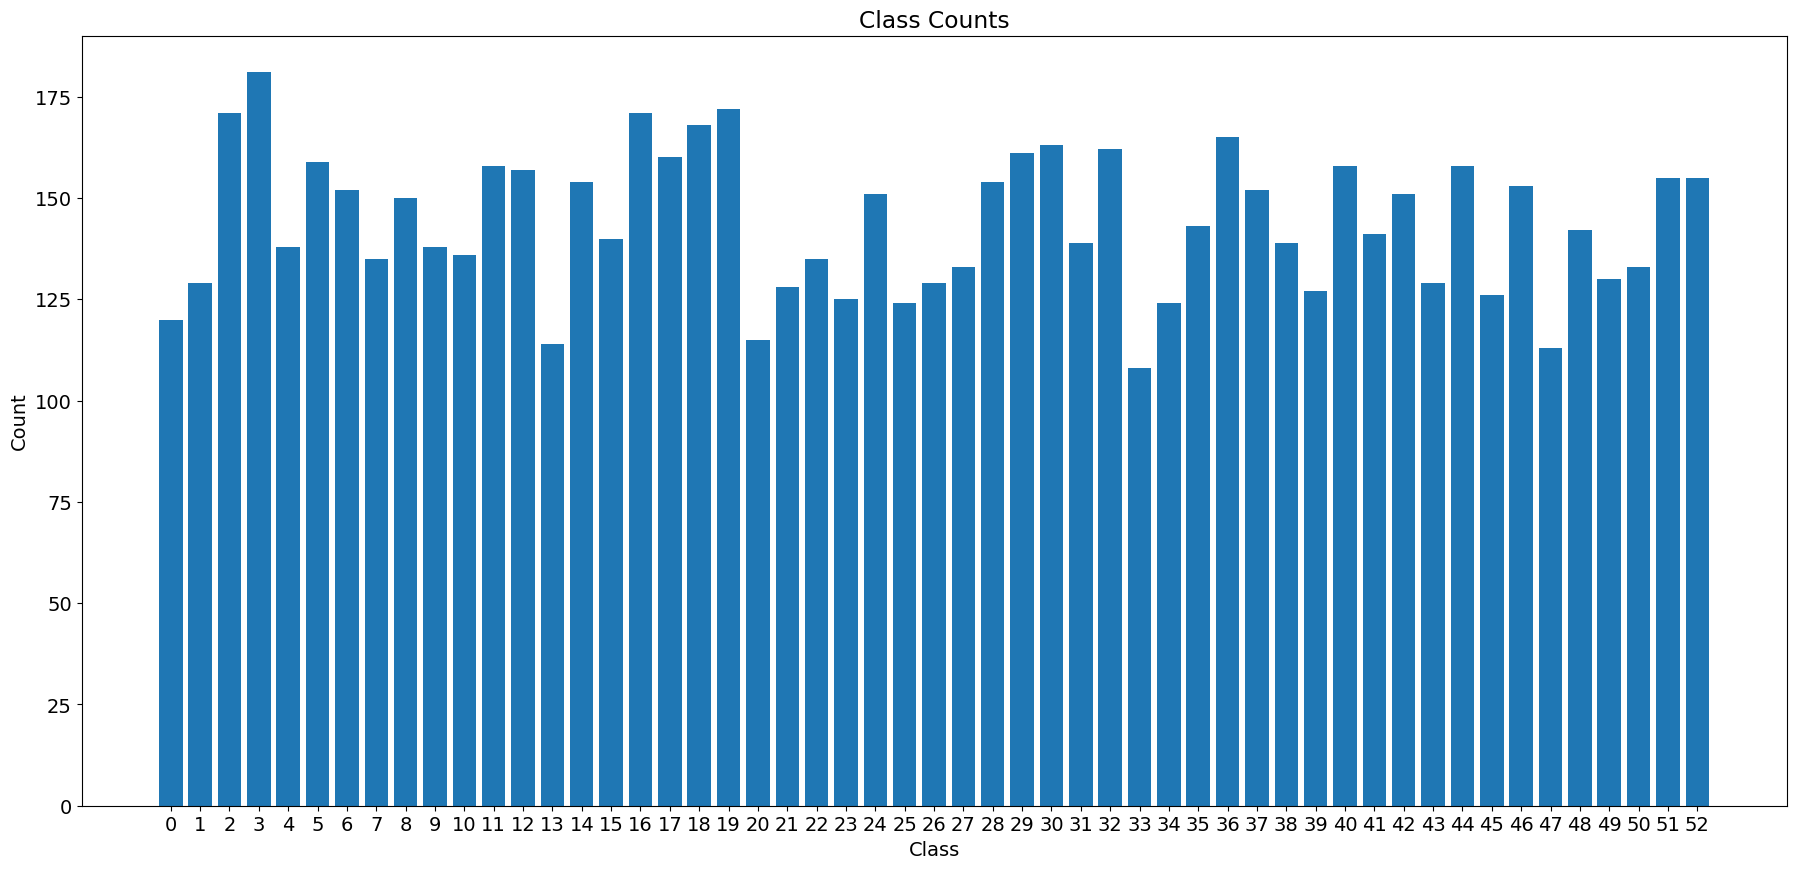

In [167]:
# Create a bar plot for class counts
plt.figure(figsize=(22, 10))
plt.bar(unique_classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Counts')
plt.xticks(np.arange(min(unique_classes), max(unique_classes) + 1, 1))
plt.show()

# Model 1: Basic model

In [168]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=img_height*img_width*3, num_classes=53, hidden_sizes=[8192, 2048, 512, 256, 128]):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [169]:
model = BaseNetwork(act_fn=nn.ReLU()).to(device)

In [170]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [171]:
criterion = nn.CrossEntropyLoss()

In [172]:
model

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=19200, out_features=8192, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8192, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=53, bias=True)
  )
)

In [173]:
def train(model, epoch, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [174]:
def validate(model, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [175]:
%%time
epochs = 25

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model, epoch)
    validate(model, lossv, accv)

Train Epoch: 1 [0/7624 (0%)]	Loss: 3.966094
Train Epoch: 1 [6400/7624 (84%)]	Loss: 3.966455

Validation set: Average loss: 3.9674, Accuracy: 5/265 (2%)

Train Epoch: 2 [0/7624 (0%)]	Loss: 3.979606
Train Epoch: 2 [6400/7624 (84%)]	Loss: 3.958509

Validation set: Average loss: 3.9570, Accuracy: 11/265 (4%)

Train Epoch: 3 [0/7624 (0%)]	Loss: 3.966908
Train Epoch: 3 [6400/7624 (84%)]	Loss: 3.925764

Validation set: Average loss: 3.9042, Accuracy: 11/265 (4%)

Train Epoch: 4 [0/7624 (0%)]	Loss: 3.875900
Train Epoch: 4 [6400/7624 (84%)]	Loss: 3.693332

Validation set: Average loss: 3.6362, Accuracy: 21/265 (8%)

Train Epoch: 5 [0/7624 (0%)]	Loss: 3.779953
Train Epoch: 5 [6400/7624 (84%)]	Loss: 3.583157

Validation set: Average loss: 3.7027, Accuracy: 12/265 (5%)

Train Epoch: 6 [0/7624 (0%)]	Loss: 3.926451
Train Epoch: 6 [6400/7624 (84%)]	Loss: 3.463831

Validation set: Average loss: 3.1913, Accuracy: 35/265 (13%)

Train Epoch: 7 [0/7624 (0%)]	Loss: 3.656288
Train Epoch: 7 [6400/7624 (84%)]

Text(0.5, 1.0, 'validation loss')

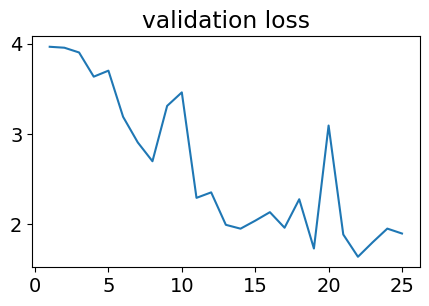

In [179]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

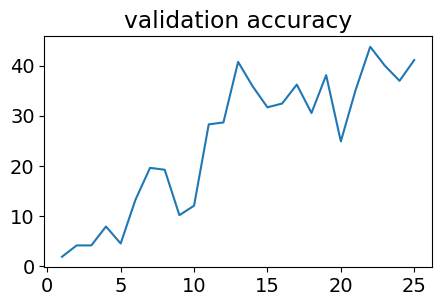

In [180]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [183]:
%%time
#more train
from_epochs = 26
to_epochs = 32
for epoch in range(from_epochs, to_epochs + 1):
    train(model, epoch)
    validate(model, lossv, accv)

Train Epoch: 26 [0/7624 (0%)]	Loss: 2.252222
Train Epoch: 26 [6400/7624 (84%)]	Loss: 2.214306

Validation set: Average loss: 1.9468, Accuracy: 103/265 (39%)

Train Epoch: 27 [0/7624 (0%)]	Loss: 2.483544
Train Epoch: 27 [6400/7624 (84%)]	Loss: 1.370115

Validation set: Average loss: 1.7558, Accuracy: 114/265 (43%)

Train Epoch: 28 [0/7624 (0%)]	Loss: 2.081817
Train Epoch: 28 [6400/7624 (84%)]	Loss: 1.892401

Validation set: Average loss: 1.8150, Accuracy: 118/265 (45%)

Train Epoch: 29 [0/7624 (0%)]	Loss: 1.806772
Train Epoch: 29 [6400/7624 (84%)]	Loss: 1.836516

Validation set: Average loss: 1.8469, Accuracy: 121/265 (46%)

Train Epoch: 30 [0/7624 (0%)]	Loss: 2.330791
Train Epoch: 30 [6400/7624 (84%)]	Loss: 1.288097

Validation set: Average loss: 2.1757, Accuracy: 95/265 (36%)

Train Epoch: 31 [0/7624 (0%)]	Loss: 1.929771
Train Epoch: 31 [6400/7624 (84%)]	Loss: 1.752905

Validation set: Average loss: 1.6613, Accuracy: 126/265 (48%)

Train Epoch: 32 [0/7624 (0%)]	Loss: 1.969564
Train Ep

Text(0.5, 1.0, 'validation loss')

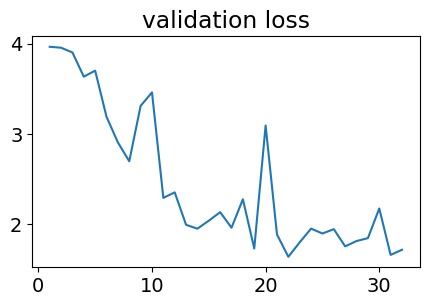

In [185]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,to_epochs+1), lossv)
plt.title('validation loss')

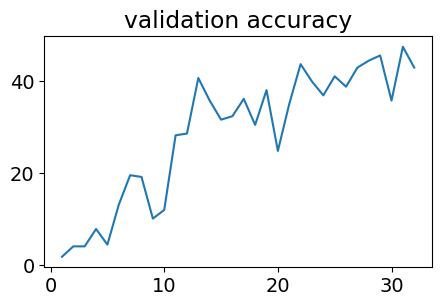

In [186]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,to_epochs+1), accv)
plt.title('validation accuracy');